In [1]:
%matplotlib widget

In [2]:
# standard library
import logging
import os
from pathlib import Path    
import sys

# third-party packages
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm

# notebook
from IPython import display

# get absolute path to file's parent directory
dir_proj_base = Path(os.getcwd()).resolve().parents[1]
sys.path.insert(0, f"{dir_proj_base}/src")

# Internal dependencies
from utils.figure_style import set_style  # noqa: E402

In [3]:
# notebook logger has DEBUG level
log = logging.getLogger("dipole_moment_notebook")
log.setLevel(logging.DEBUG)

# console handler
format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(format)
log.addHandler(ch)

In [4]:
# set plotting style
set_style()

In [5]:
# set thermal energy
TEMPERATURE_K: float = 300  # [K] # system temperature
KB = 8.314462618e-3  # [kJ/mol/K]
kbt = KB * TEMPERATURE_K  # [kJ/mol]

In [6]:
def plumed_df(file: Path) -> pd.DataFrame:
    # input checking
    if not file.exists():
        log.error(f"File {file} does not exist")
        sys.exit(1)

    # first line of file contains column names
    with open(str(file), encoding="utf8") as f:
        header = f.readline()
    header = header.split()[2:]  # remove "#!" FIELDS
    n_cols = len(header)

    # read in data
    df = pd.read_csv(
        str(file),
        names=header,
        comment="#",
        delim_whitespace=True,
        skipinitialspace=True,
        usecols=list(range(n_cols)),
    )
    return df


In [7]:
n_ca = 32
data_dir = Path(f"/home/aglisman/VSCodeProjects/Polyelectrolyte-Surface-Adsorption/data/sjobid_0-calcite-104surface-12nm_surface-13nm_vertical-1chain-PAcr-32mer-0Crb-{n_ca}Ca-32Na-{2*n_ca}Cl-300K-1bar-NVT/3-sampling-opes-explore")
fname = "COLVAR.data"

# read in data
file = data_dir / fname
data = plumed_df(file)

In [8]:
data.head()

,time,dist_chain.x,dist_chain.y,dist_chain.z,opes.bias,opes.rct,opes.zed,opes.neff,opes.nker,opes.work,rg_chain,cn_ca_co,dist_ca.x,dist_ca.y,dist_ca.z,upper_wall.bias,upper_wall.force2,lower_wall.bias,lower_wall.force2
0,0.0,-11.215070,-3.176902,2.292760,-50.0,-50.0,1.0,1.0,0.0,0.0,1.580392,13.960772,-10.980700,8.578706,17.944180,0.0,0.0,0.0,0.0
1,1.0,-11.228890,-3.176233,2.278957,-50.0,-50.0,1.0,1.0,0.0,0.0,1.580840,13.462123,-10.980053,8.581374,17.928584,0.0,0.0,0.0,0.0
2,2.0,-11.237185,-3.196268,2.281423,-50.0,-50.0,1.0,1.0,0.0,0.0,1.592018,13.956126,-10.984153,8.577699,17.933867,0.0,0.0,0.0,0.0
3,3.0,-11.221899,-3.205414,2.292008,-50.0,-50.0,1.0,1.0,0.0,0.0,1.582668,13.591163,-10.974280,8.775261,7.738530,0.0,0.0,0.0,0.0
4,4.0,-11.223847,-3.202425,2.274675,-50.0,-50.0,1.0,1.0,0.0,0.0,1.583964,13.792279,-10.973067,8.543115,19.905267,0.0,0.0,0.0,0.0


In [9]:
# print all column names
for col in data.columns:
    print(col)

log.info(f"Number of rows: {len(data)}")
log.info(f"Number of columns: {len(data.columns)}")

time
dist_chain.x
dist_chain.y
dist_chain.z
opes.bias
opes.rct
opes.zed
opes.neff
opes.nker
opes.work
rg_chain
cn_ca_co
dist_ca.x
dist_ca.y
dist_ca.z
upper_wall.bias
upper_wall.force2
lower_wall.bias
lower_wall.force2
2023-09-27 16:55:35,102 - dipole_moment_notebook - INFO - Number of rows: 425761
2023-09-27 16:55:35,103 - dipole_moment_notebook - INFO - Number of columns: 19


In [10]:
# calculate overall bias
data["bias"] = data["opes.bias"] + data["upper_wall.bias"] + data["lower_wall.bias"]
data["bias_nondim"] = (data["bias"] - np.nanmax(data["bias"])) / kbt
data["weight"] = np.exp(data["bias_nondim"])
log.debug(f"(min, max) weight: ({np.nanmin(data['weight'])}, {np.nanmax(data['weight'])})")
log.debug(f"(0.25, 0.75) weight: ({np.nanpercentile(data['weight'], 25)}, {np.nanpercentile(data['weight'], 75)})")

2023-09-27 16:55:35,129 - dipole_moment_notebook - DEBUG - (min, max) weight: (4.418723608701969e-18, 1.0)
2023-09-27 16:55:35,135 - dipole_moment_notebook - DEBUG - (0.25, 0.75) weight: (2.1266524365331552e-07, 7.431521967897584e-06)


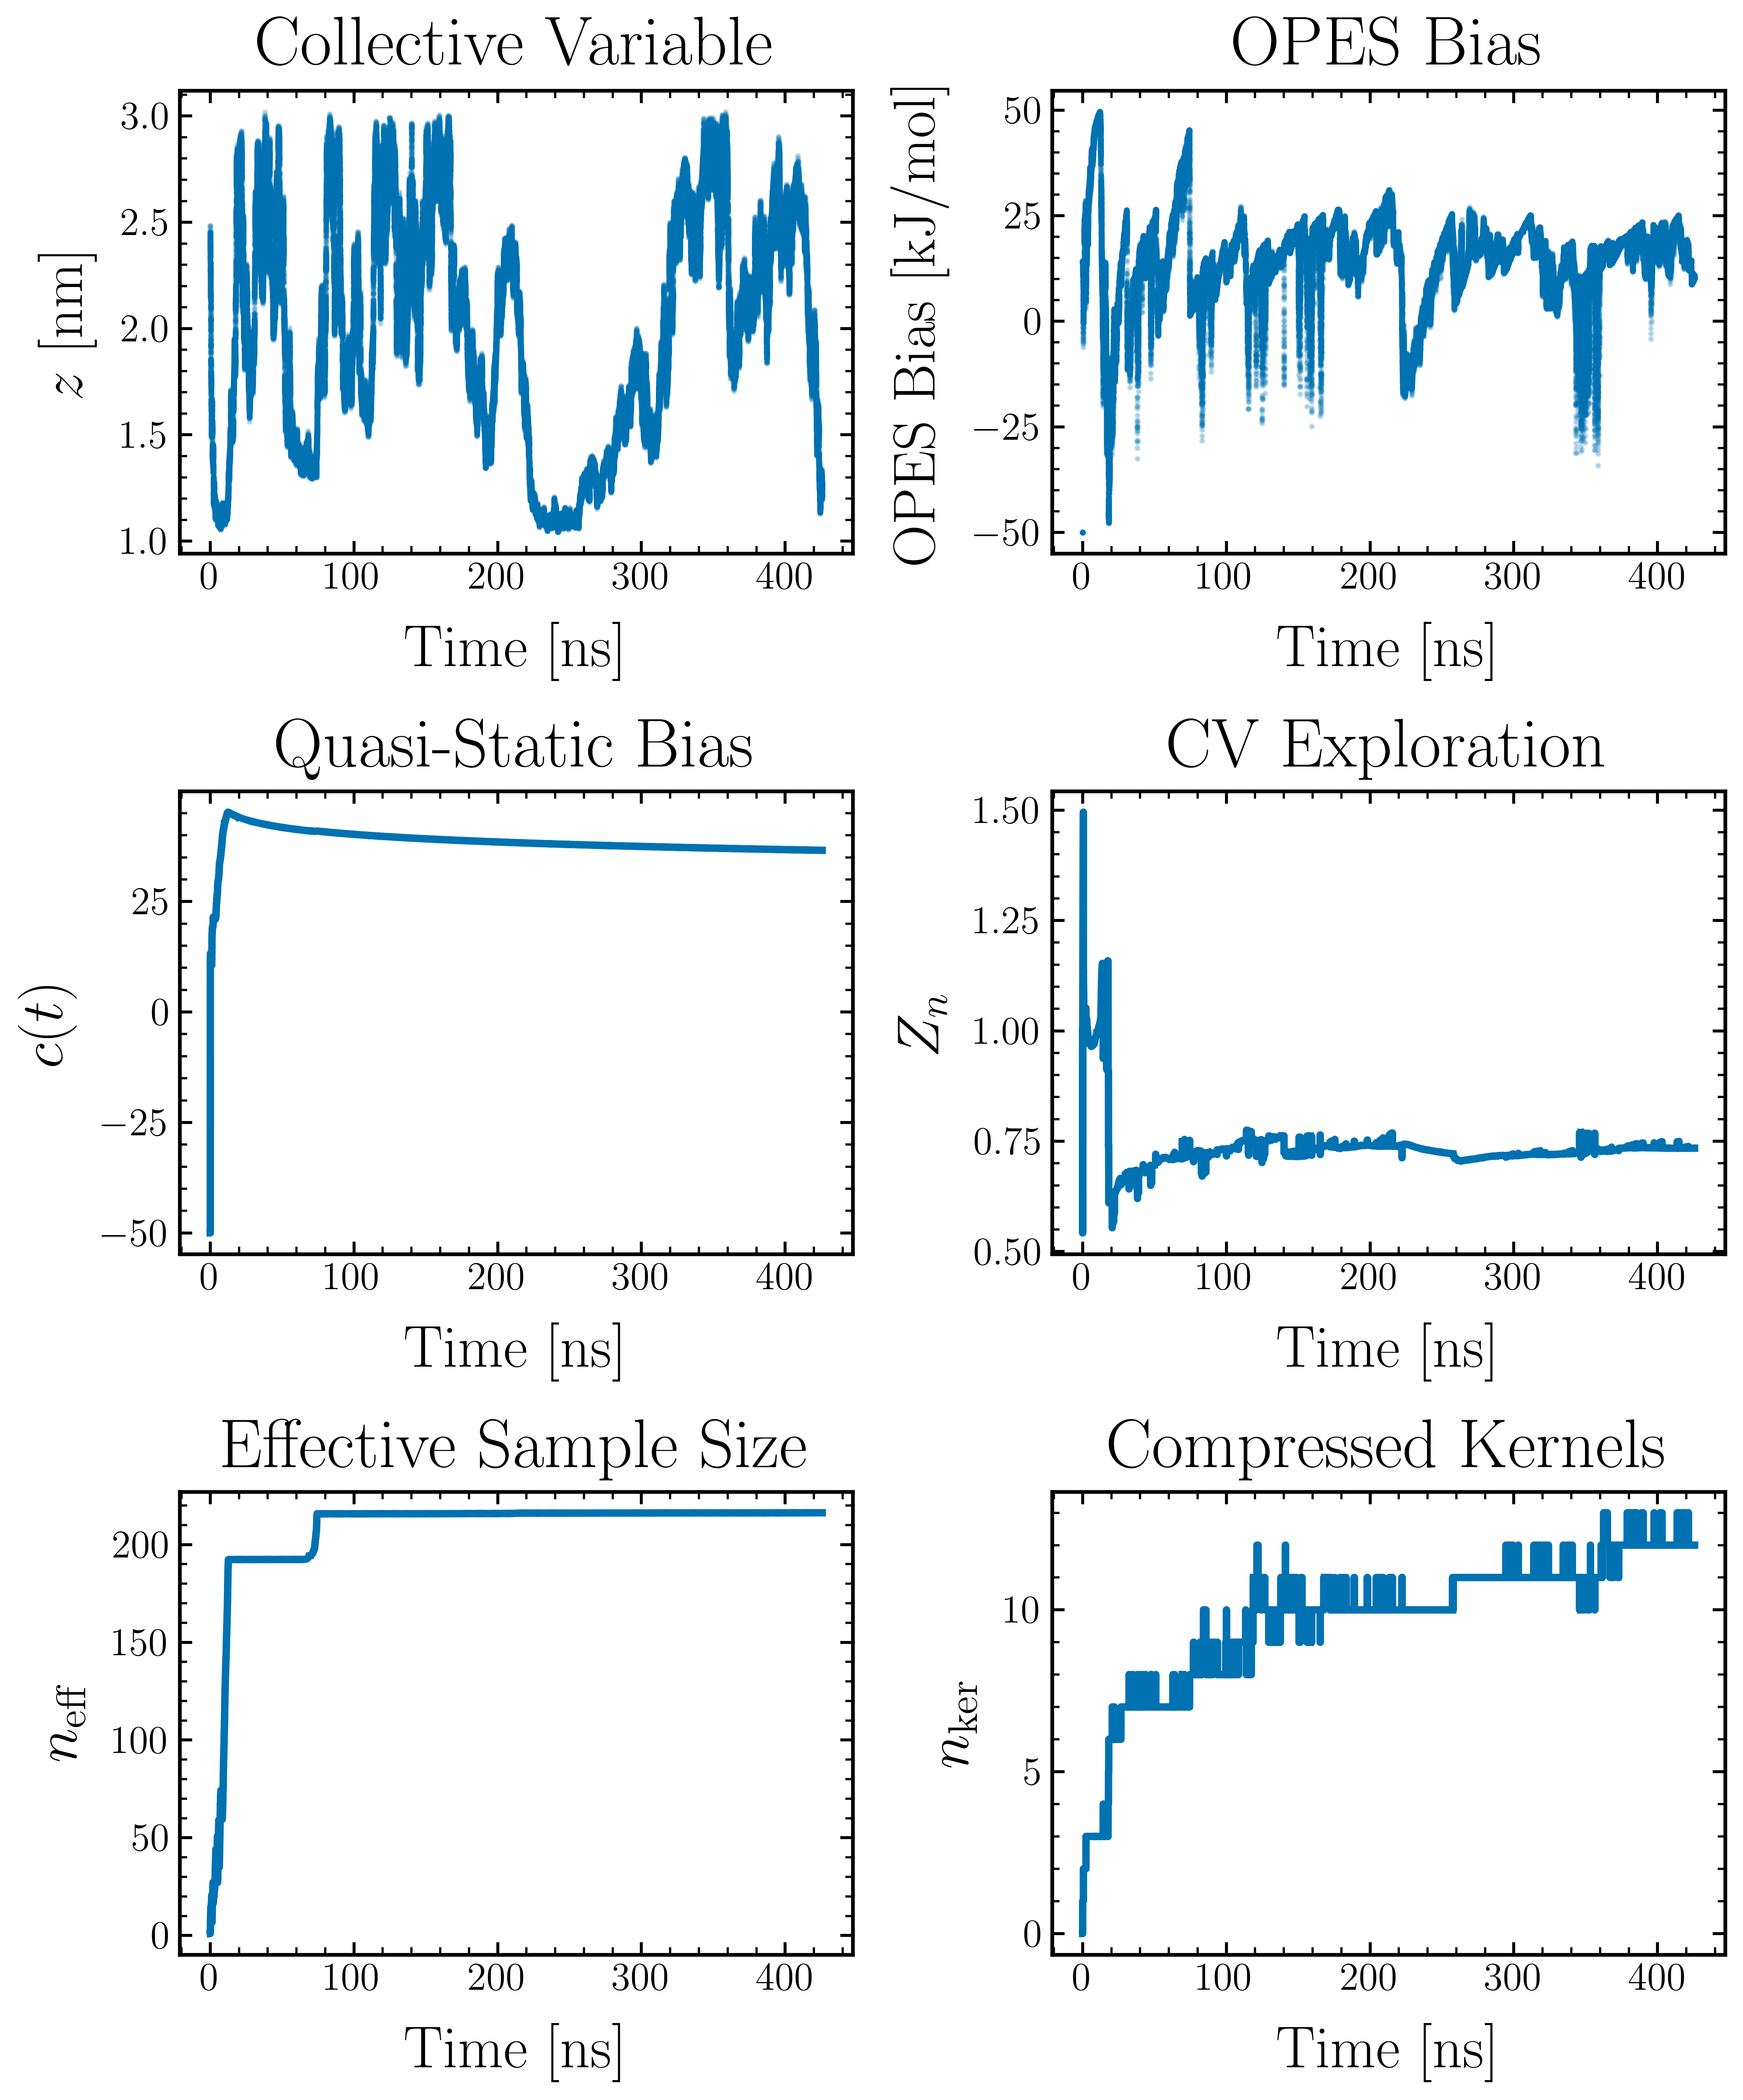

In [11]:
# plot the dynamics of key CVs and simulation variables (3 rows x 2 columns = 6 subplots)
fig = plt.figure(figsize=(10, 12))
fname = "opes_statistics.png"

# CV: curve should show rapid sampling of the entire CV space
ax1 = fig.add_subplot(321)
ax1.set_xlabel("Time [ns]", labelpad=10)
ax1.set_ylabel("$z$ [nm]", labelpad=10)
ax1.set_title("Collective Variable", pad=10)
ax1.scatter(data["time"]/1e3, data["dist_chain.z"], s=2, alpha=0.2)

# OPES Bias: bias should be slowly increasing over time
ax2 = fig.add_subplot(322)
ax2.set_xlabel("Time [ns]", labelpad=10)
ax2.set_ylabel("OPES Bias [kJ/mol]", labelpad=10)
ax2.set_title("OPES Bias", pad=10)
ax2.scatter(data["time"]/1e3, data["opes.bias"], s=2, alpha=0.2)

# OPES time constant: should increase and converge to a constant as the bias becomes quasi-static
ax3 = fig.add_subplot(323)
ax3.set_xlabel("Time [ns]", labelpad=10)
ax3.set_ylabel("$c{(t)}$", labelpad=10)
ax3.set_title("Quasi-Static Bias", pad=10)
ax3.plot(data["time"]/1e3, data["opes.rct"], linewidth=3)

# OPES normalization constant: starts from 1 an changes significantly when a new region of CV space is explored
ax4 = fig.add_subplot(324)
ax4.set_xlabel("Time [ns]", labelpad=10)
ax4.set_ylabel("$Z_n$", labelpad=10)
ax4.set_title("CV Exploration", pad=10)
ax4.plot(data["time"]/1e3, data["opes.zed"], linewidth=3)

# OPES number of effective samples: should be increasing over time with a fixed ratio to the number of samples
ax5 = fig.add_subplot(325)
ax5.set_xlabel("Time [ns]", labelpad=10)
ax5.set_ylabel("$n_\mathrm{eff}$", labelpad=10)
ax5.set_title("Effective Sample Size", pad=10)
ax5.plot(data["time"]/1e3, data["opes.neff"], linewidth=3)

# OPES number of compressed kernels: should increase and plateau
ax6 = fig.add_subplot(326)
ax6.set_xlabel("Time [ns]", labelpad=10)
ax6.set_ylabel("$n_\mathrm{ker}$", labelpad=10)
ax6.set_title("Compressed Kernels", pad=10)
ax6.plot(data["time"]/1e3, data["opes.nker"], linewidth=3)


# save figure
fig.tight_layout()
fig.savefig(fname, dpi=600, bbox_inches="tight")
plt.close(fig)

# display figure
display.Image(fname, width=800)


In [12]:
def fes_dist(
        x: np.ndarray, 
        weights: np.ndarray = None, 
        bandwidth: float = 0.1,
        min_val: float = None,
        max_val: float = None,
    ) -> tuple[np.ndarray, np.ndarray]:
    """Calculate the free energy surface for a given distance collective variable.

    Parameters
    ----------
    x : np.ndarray
        Array of distances.
    weights : np.ndarray, optional
        Array of weights, by default None
    bandwidth : float, optional
        Bandwidth for kernel density estimation, by default 0.1
    min_val : float, optional
        Minimum value of distance, by default None
    max_val : float, optional
        Maximum value of distance, by default None
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Tuple of arrays of distances and free energies.

    Raises
    ------
    ValueError
        If `min_val` is not less than `max_val`.
    """
    # input checking
    if min_val is None:
        min_val = np.nanmin(x)
    if max_val is None:
        max_val = np.nanmax(x)
    if min_val >= max_val:
        raise ValueError(f"min_val ({min_val}) must be less than max_val ({max_val})")
    
    # calculate KDE of x weighted by weights
    x_grid = np.linspace(min_val, max_val, 300)
    kde = stats.gaussian_kde(x, weights=weights, bw_method=bandwidth)
    fes = - kde.logpdf(x_grid)

    # apply distance correction
    fes += 2 * np.log(x_grid)

    # set minimum to zero
    fes -= np.nanmin(fes)

    return x_grid, fes


In [13]:
# calculate free energy surface at the end of the simulation
bandwidth = 0.5
min_val = 0.8
max_val = 2.5
start_frame = int(0.1 * len(data))
cv = "dist_chain.z"

log.debug(f"Number of samples: {len(data)}")
log.debug(f"KDE Bandwidth: {bandwidth}")
log.debug(f"Min val in KDE grid: {min_val}")
log.debug(f"Max val in KDE grid: {max_val}")

x_grid, fes = fes_dist(
    data[cv].to_numpy()[start_frame:],
    weights=data["weight"].to_numpy()[start_frame:],
    bandwidth=bandwidth, 
    min_val=min_val, 
    max_val=max_val, 
)

2023-09-27 16:55:40,116 - dipole_moment_notebook - DEBUG - Number of samples: 425761
2023-09-27 16:55:40,116 - dipole_moment_notebook - DEBUG - KDE Bandwidth: 0.5
2023-09-27 16:55:40,117 - dipole_moment_notebook - DEBUG - Min val in KDE grid: 0.8
2023-09-27 16:55:40,117 - dipole_moment_notebook - DEBUG - Max val in KDE grid: 2.5


In [ ]:
# plot free energy surface
ymax = 15
fname = "pmf.png"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Potential of Mean Force", pad=10)
ax.set_xlabel(r"$z$ [nm]", labelpad=10)
ax.set_ylabel(r"$\Delta F$ [$k_\mathrm{B}T$]", labelpad=10)
ax.set_ylim((0, ymax))

ax.plot(x_grid, fes, linewidth=3)

fig.tight_layout()
fig.savefig(fname, dpi=600, bbox_inches="tight")


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7fc639cee1d0>>
Traceback (most recent call last):
  File "/home/aglisman/miniconda3/envs/analysis/lib/python3.10/site-packages/pandas/core/indexes/range.py", line 391, in get_loc
    return self._range.index(new_key)
ValueError: 432576 is not in range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/aglisman/miniconda3/envs/analysis/lib/python3.10/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/home/aglisman/miniconda3/envs/analysis/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 1226, in _on_timer
    ret = func(*args, **kwargs)
  File "/home/aglisman/miniconda3/envs/analysis/lib/python3.10/site-packages/matplotlib/animation.py", line 1426, in _step
    still_going = super()._step(*args)
  File "/home/aglisman/m

In [ ]:
# plot the free energy surface as a function of time as a movie
step = 1000
fname = "pmf.mp4"

# setup figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$z$ [nm]", labelpad=10)
ax.set_ylabel(r"$\Delta F$ [$k_\mathrm{B}T$]", labelpad=10)
ax.set_ylim((0, ymax))
ax.set_title("Potential of Mean Force", pad=10)

# initialize plot elements
idx = start_frame + step
curve = ax.plot(x_grid, np.zeros_like(x_grid), linewidth=3)
text = ax.text(0.5, 0.9, f"$t_f = ${data['time'][idx]/1e3:.2f} ns", transform=ax.transAxes, ha="center")

def animate(frame_num: int):
    global idx, start_frame
    global curve, text
    global data, cv, bandwidth, min_val, max_val

    # update curve
    _, fes = fes_dist(
        data[cv][start_frame:idx].to_numpy(),
        weights=data["weight"][start_frame:idx].to_numpy(),
        bandwidth=bandwidth, 
        min_val=min_val, 
        max_val=max_val,
    )
    curve[0].set_ydata(fes)

    # update text
    time = data["time"].loc[idx] / 1e3
    text.set_text(f"$t_f = $ {time:.1f} ns")

    # update index
    idx += step

    return curve, text


# animate
n_frames = (len(data) - start_frame) // step - 2
stop_frame = data[start_frame::step].index[-1]
log.debug(f"Number of frames: {n_frames}")
log.debug(f"Stop frame: {stop_frame}")
log.info(f"Creating animation")
anim = animation.FuncAnimation(
    fig, 
    animate, 
    blit=True,
    frames=n_frames,
)

# create tqdm progress bar
log.info(f"Saving animation as {fname}")
prog = tqdm(total=n_frames, desc="Saving animation", unit="frame", dynamic_ncols=True, colour="green")

# save animation as mp4 and output tqdm progress bar
anim.save(
    fname, 
    writer="ffmpeg", 
    fps=30, 
    dpi=300,
    progress_callback=lambda i, _: prog.update(1),
)
plt.close()
log.debug(f"Final time rendered: {data['time'].loc[idx] / 1e3:.2f} ns")
log.debug(f"Final simulation time: {data['time'].to_numpy()[-1] / 1e3:.2f} ns")

# display video in notebook
log.info(f"Displaying animation")
video = display.Video(fname, embed=True, width=700)
display.display(video)
